In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

import sys
from datetime import datetime

class Logger:
    def __init__(self, filename="log.txt"):
        self.terminal = sys.stdout
        self.log = open(filename, "a", encoding='utf-8')

    def write(self, message):
        self.terminal.write(message)   # Display in terminal
        self.log.write(message)        # Write to file

    def flush(self):
        self.terminal.flush()
        self.log.flush()

# Set up logger
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
log_filename = f"log_{timestamp}.txt"
sys.stdout = Logger(log_filename)


In [316]:
def normalize_image(img, target_mean, target_std ):
    # Compute mean and standard deviation
    mean_gray = np.mean(img)
    std_gray = np.std(img)
    
    # Normalize image
    norm_img = (img - mean_gray) / std_gray  # Standardize
    norm_img = (norm_img * target_std) + target_mean  # Scale to new distribution
    
    # Clip values to valid range
    norm_img = np.clip(norm_img, 0, 255).astype(np.uint8)
    return norm_img

In [ ]:
def plot_histograms(image_path, crop_gray=False, crop_cdf=True):

    # Read image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Error: Could not load image.")
        return
    
    target_mean = 0.4776*255
    target_std = 0.2238*255
    gray_mean = np.mean(img)
    gray_std= np.std(img)

    # Compute grayscale histogram
    hist = cv2.calcHist([img], [0], None, [256], [0, 256])
    if crop_gray:
        hist[:5] = 0
        hist[-5:] = 0
    
    # Compute sum of grayscale values along x-axis (rows)
    gray_sum_rows = np.sum(img, axis=1)
    
    # Compute sum of grayscale values along y-axis (columns)
    gray_sum_columns = np.sum(img, axis=0)
    
    # Calculate CDF of gray_sum_rows
    gray_sum_rows_cdf = np.cumsum(gray_sum_rows) / np.sum(gray_sum_rows)
    
    # Calculate CDF of gray_sum_columns
    gray_sum_columns_cdf = np.cumsum(gray_sum_columns) / np.sum(gray_sum_columns)

    x_min = None
    x_max = None
    y_min = None
    y_max = None
    if crop_cdf:
        # Find the indices for 0.1 and 0.9 CDF for x and y
        x_min = np.searchsorted(gray_sum_columns_cdf, 0.05)
        x_max = np.searchsorted(gray_sum_columns_cdf, 0.95)
        y_min = np.searchsorted(gray_sum_rows_cdf, 0.15)
        y_max = np.searchsorted(gray_sum_rows_cdf, 0.95)
        
        # Crop the image
        img_crop = img[ y_min:y_max,x_min:x_max]
        img_crop = cv2.resize(img_crop, (224,224))
        
        norm_img_crop = normalize_image(img_crop, target_mean, target_std )
            
        norm_gray_mean = np.mean(norm_img_crop)
        norm_gray_std= np.std(norm_img_crop)
        
        # Compute grayscale histogram
        norm_hist = cv2.calcHist([norm_img_crop], [0], None, [256], [0, 256])
        if crop_gray:
            norm_hist[:5] = 0
            norm_hist[-5:] = 0

    # Plot histograms
    plt.figure(figsize=(20, 20))

    # Image
    plt.subplot(331)
    plt.imshow(img, cmap='gray')
    plt.title("Image")
    plt.xlabel("Width")
    plt.ylabel("Height")
    
    # Gray Sum X-axis Histogram
    plt.subplot(332)
    # plt.plot(gray_sum_x, color='blue')
    plt.plot( gray_sum_rows,np.arange(len(gray_sum_rows)), color='blue')
    plt.title("Gray Sum X-axis")
    plt.xlabel("Sum of Grayscale Values")
    plt.ylabel("Row Index")
    plt.gca().invert_yaxis()
    plt.grid()
    
    # Plot CDF
    plt.subplot(333)
    plt.plot(gray_sum_rows_cdf, np.arange(len(gray_sum_rows_cdf)), color='blue')
    plt.title("CDF of Gray Sum X-axis")
    plt.xlabel("Cumulative Distribution")
    plt.ylabel("Row Index")
    plt.gca().invert_yaxis()
    plt.grid()
    plt.hlines(y_min, min(gray_sum_rows_cdf), max(gray_sum_rows_cdf), color='red', linestyle='dashed', label='y_min (CDF=0.15)')
    plt.hlines(y_max, min(gray_sum_rows_cdf), max(gray_sum_rows_cdf), color='red', linestyle='dashed', label='y_max (CDF=0.95)')
    plt.legend()
    
    # Gray Sum Y-axis Histogram
    plt.subplot(334)
    plt.plot(gray_sum_columns, color='green')
    plt.title("Gray Sum Y-axis")
    plt.xlabel("Column Index")
    plt.ylabel("Sum of Grayscale Values")
    plt.grid()

    # Plot CDF
    plt.subplot(337)
    plt.plot(gray_sum_columns_cdf, color='green')
    plt.title("CDF of Gray Sum Y-axis")
    plt.xlabel("Column Index")
    plt.ylabel("Cumulative Distribution")
    plt.grid()
    plt.vlines(x_min, min(gray_sum_columns_cdf), max(gray_sum_columns_cdf), color='red', linestyle='dashed', label='x_min (CDF=0.05)')
    plt.vlines(x_max, min(gray_sum_columns_cdf), max(gray_sum_columns_cdf), color='red', linestyle='dashed', label='x_max (CDF=0.95)')
    plt.legend()
    
    # Grayscale Histogram
    plt.subplot(335)
    plt.plot(hist, color='black')
    plt.title("Grayscale Histogram")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.grid()
    plt.vlines(target_mean, min(hist), max(hist), color='yellow', linestyle='-', label='Mean (Target)',linewidth=4)
    plt.vlines(target_mean+target_std, min(hist), max(hist), color='yellow', linestyle='dashed', label='Mean+std (Target)',linewidth=4)
    plt.vlines(gray_mean, min(hist), max(hist), color='red', linestyle='-', label='Mean')
    plt.vlines(gray_mean+gray_std, min(hist), max(hist), color='red', linestyle='dashed', label='Mean-std')
    plt.legend()

    if crop_cdf:
        # Image Crop
        plt.subplot(338)
        plt.imshow(img_crop, cmap='gray')
        plt.title("Image Crop")
        plt.xlabel("Width")
        plt.ylabel("Height")

        # Image Crop
        plt.subplot(339)
        plt.imshow(norm_img_crop, cmap='gray')
        plt.title("Image Crop & Normalized")
        plt.xlabel("Width")
        plt.ylabel("Height")
                
        # Grayscale Histogram
        plt.subplot(336)
        plt.plot(norm_hist, color='black')
        plt.title("Grayscale Histogram (Cropped & Normalized)")
        plt.xlabel("Pixel Value")
        plt.ylabel("Frequency")
        plt.grid()
        plt.vlines(target_mean, min(norm_hist), max(norm_hist), color='yellow', linestyle='-', label='Mean (Target)',linewidth=4)
        plt.vlines(target_mean+target_std, min(norm_hist), max(norm_hist), color='yellow', linestyle='dashed', label='Mean+std (Target)',linewidth=4)
        plt.vlines(norm_gray_mean, min(norm_hist), max(norm_hist), color='red', linestyle='-', label='Mean')
        plt.vlines(norm_gray_mean+norm_gray_std, min(norm_hist), max(norm_hist), color='red', linestyle='dashed', label='Mean-std')
        plt.legend()
        

    plt.tight_layout()
    plt.savefig("histogram_analysis.png", dpi=300, bbox_inches='tight')  # Save to file
    plt.show()


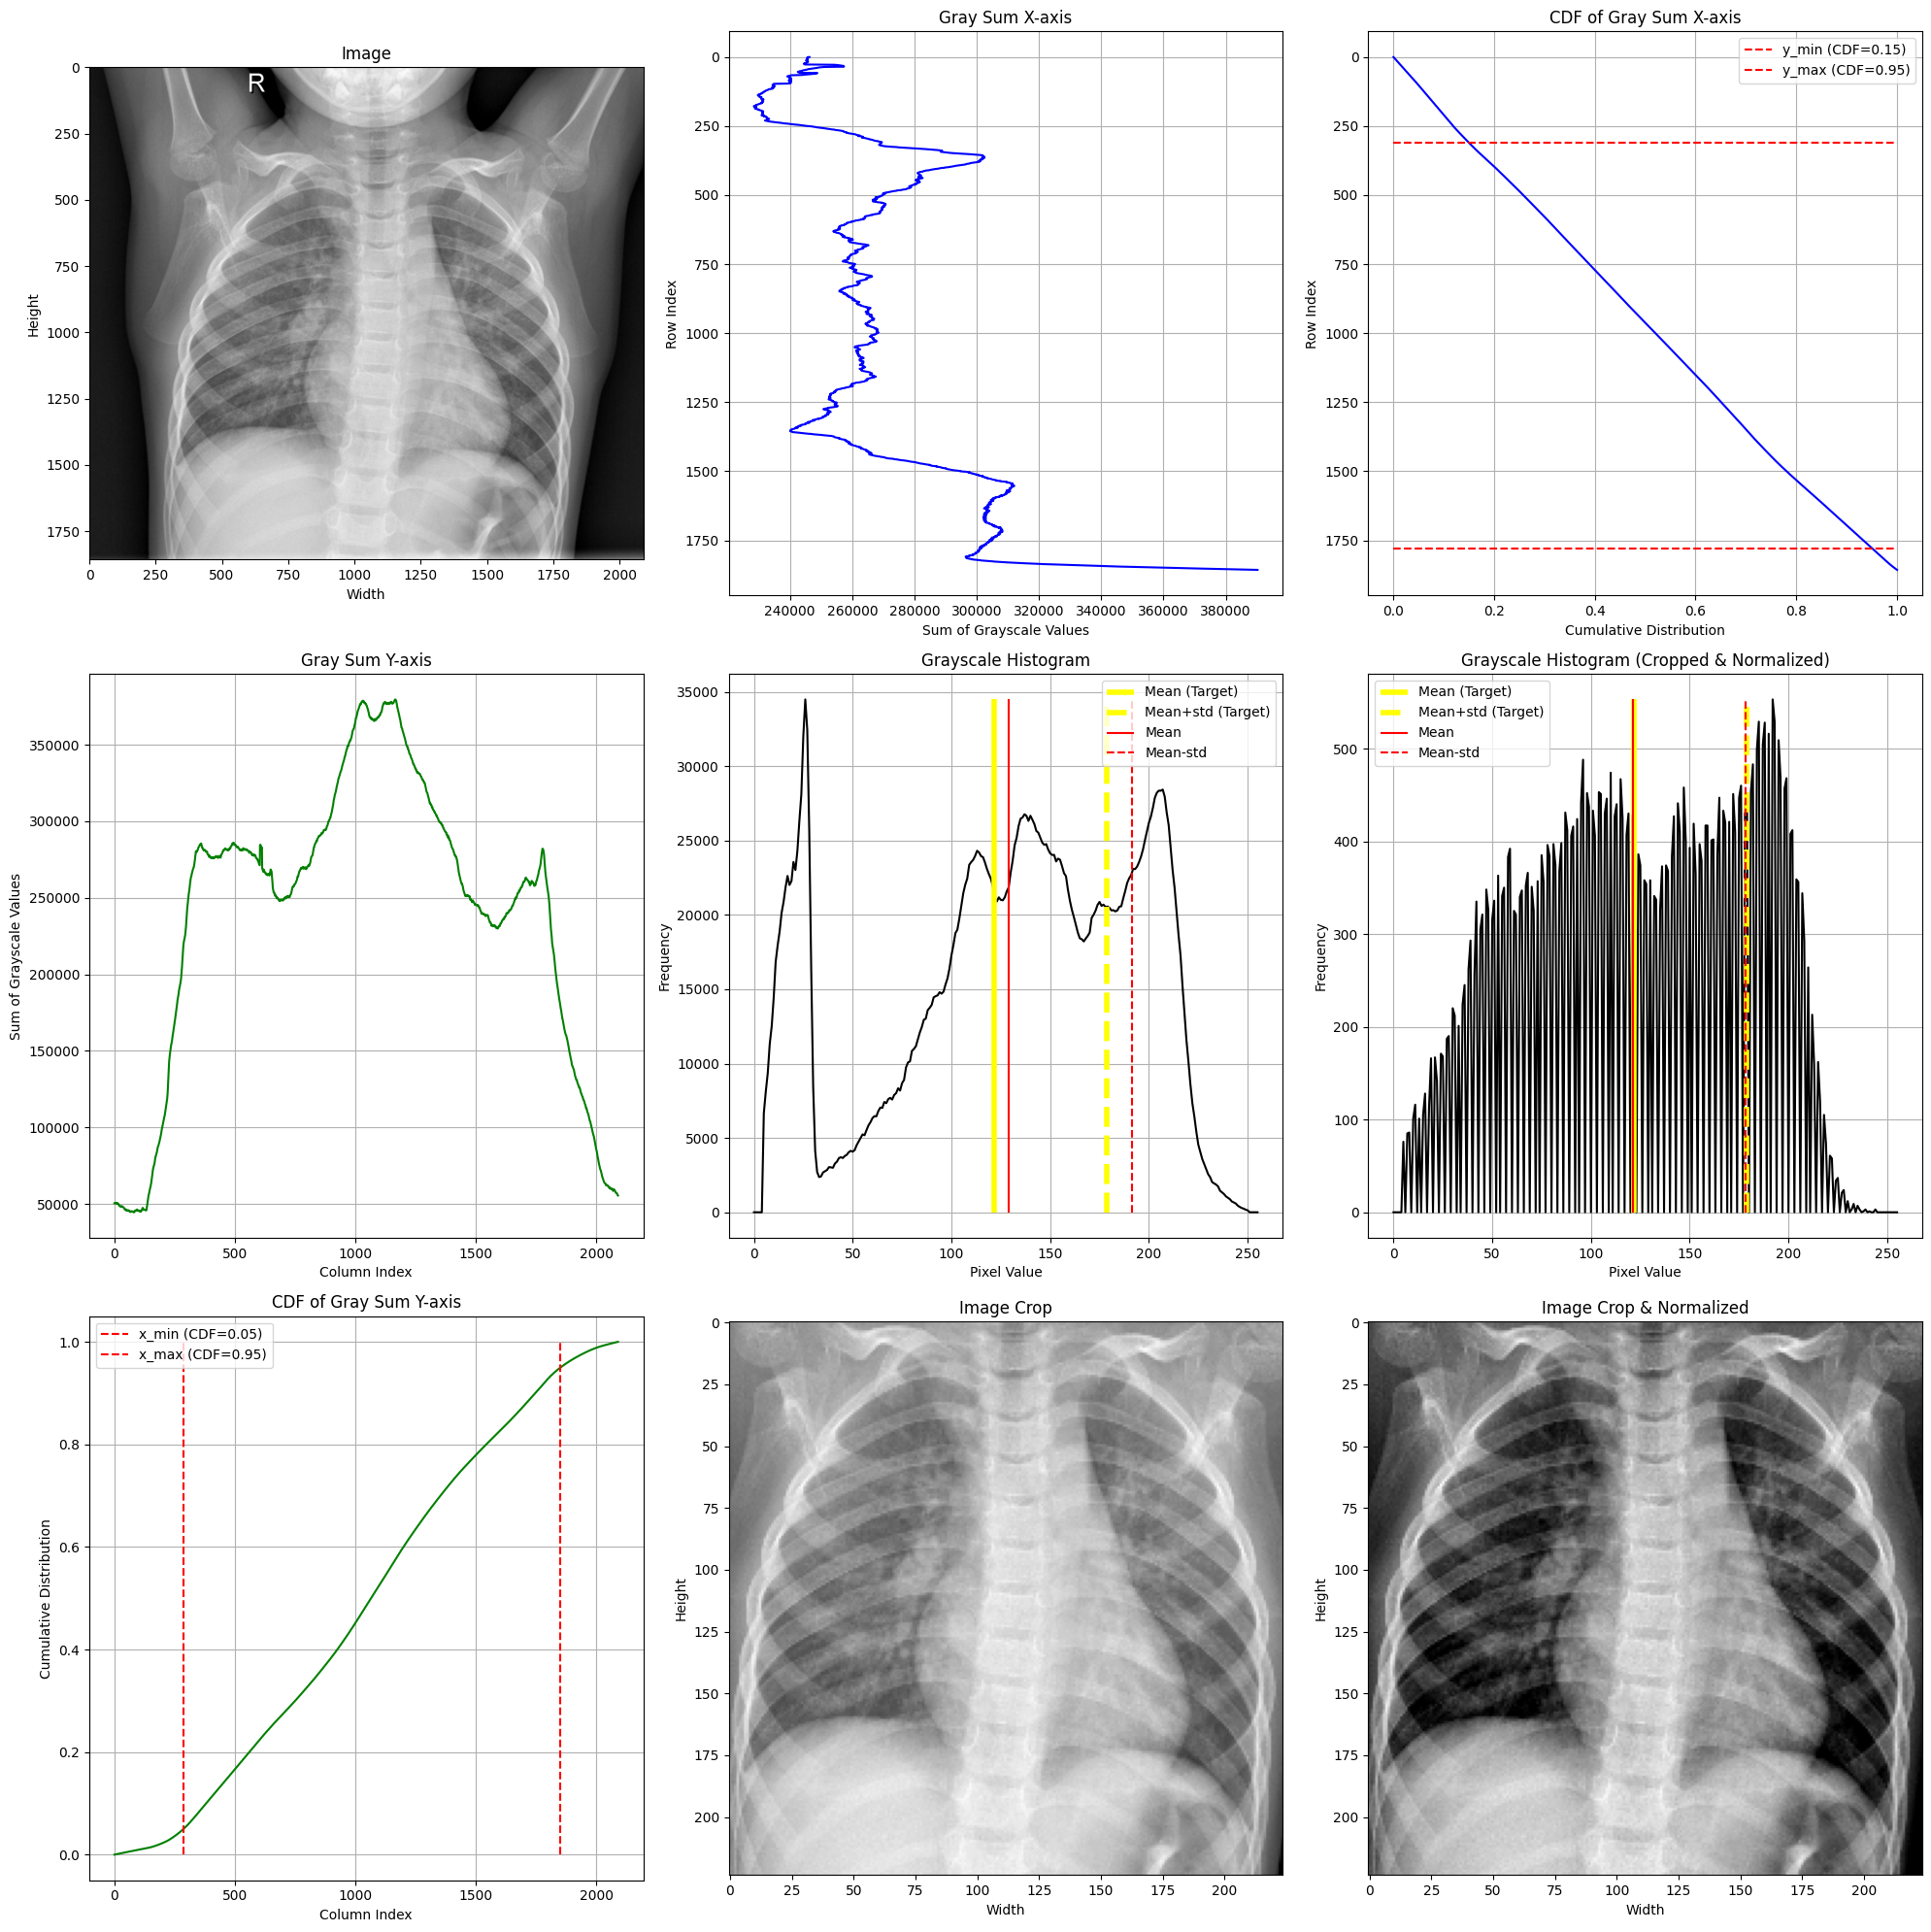

In [318]:
data_dir = r"C:\Users\Study\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2\chest_xray"
date_set = 'train'
class_name = 'NORMAL' # 'PNEUMONIA'
img_name = 'IM-0115-0001.jpeg'# Example usage
image_path = os.path.join(data_dir, date_set, class_name, img_name)
plot_histograms(image_path, crop_gray=True,crop_cdf=True)

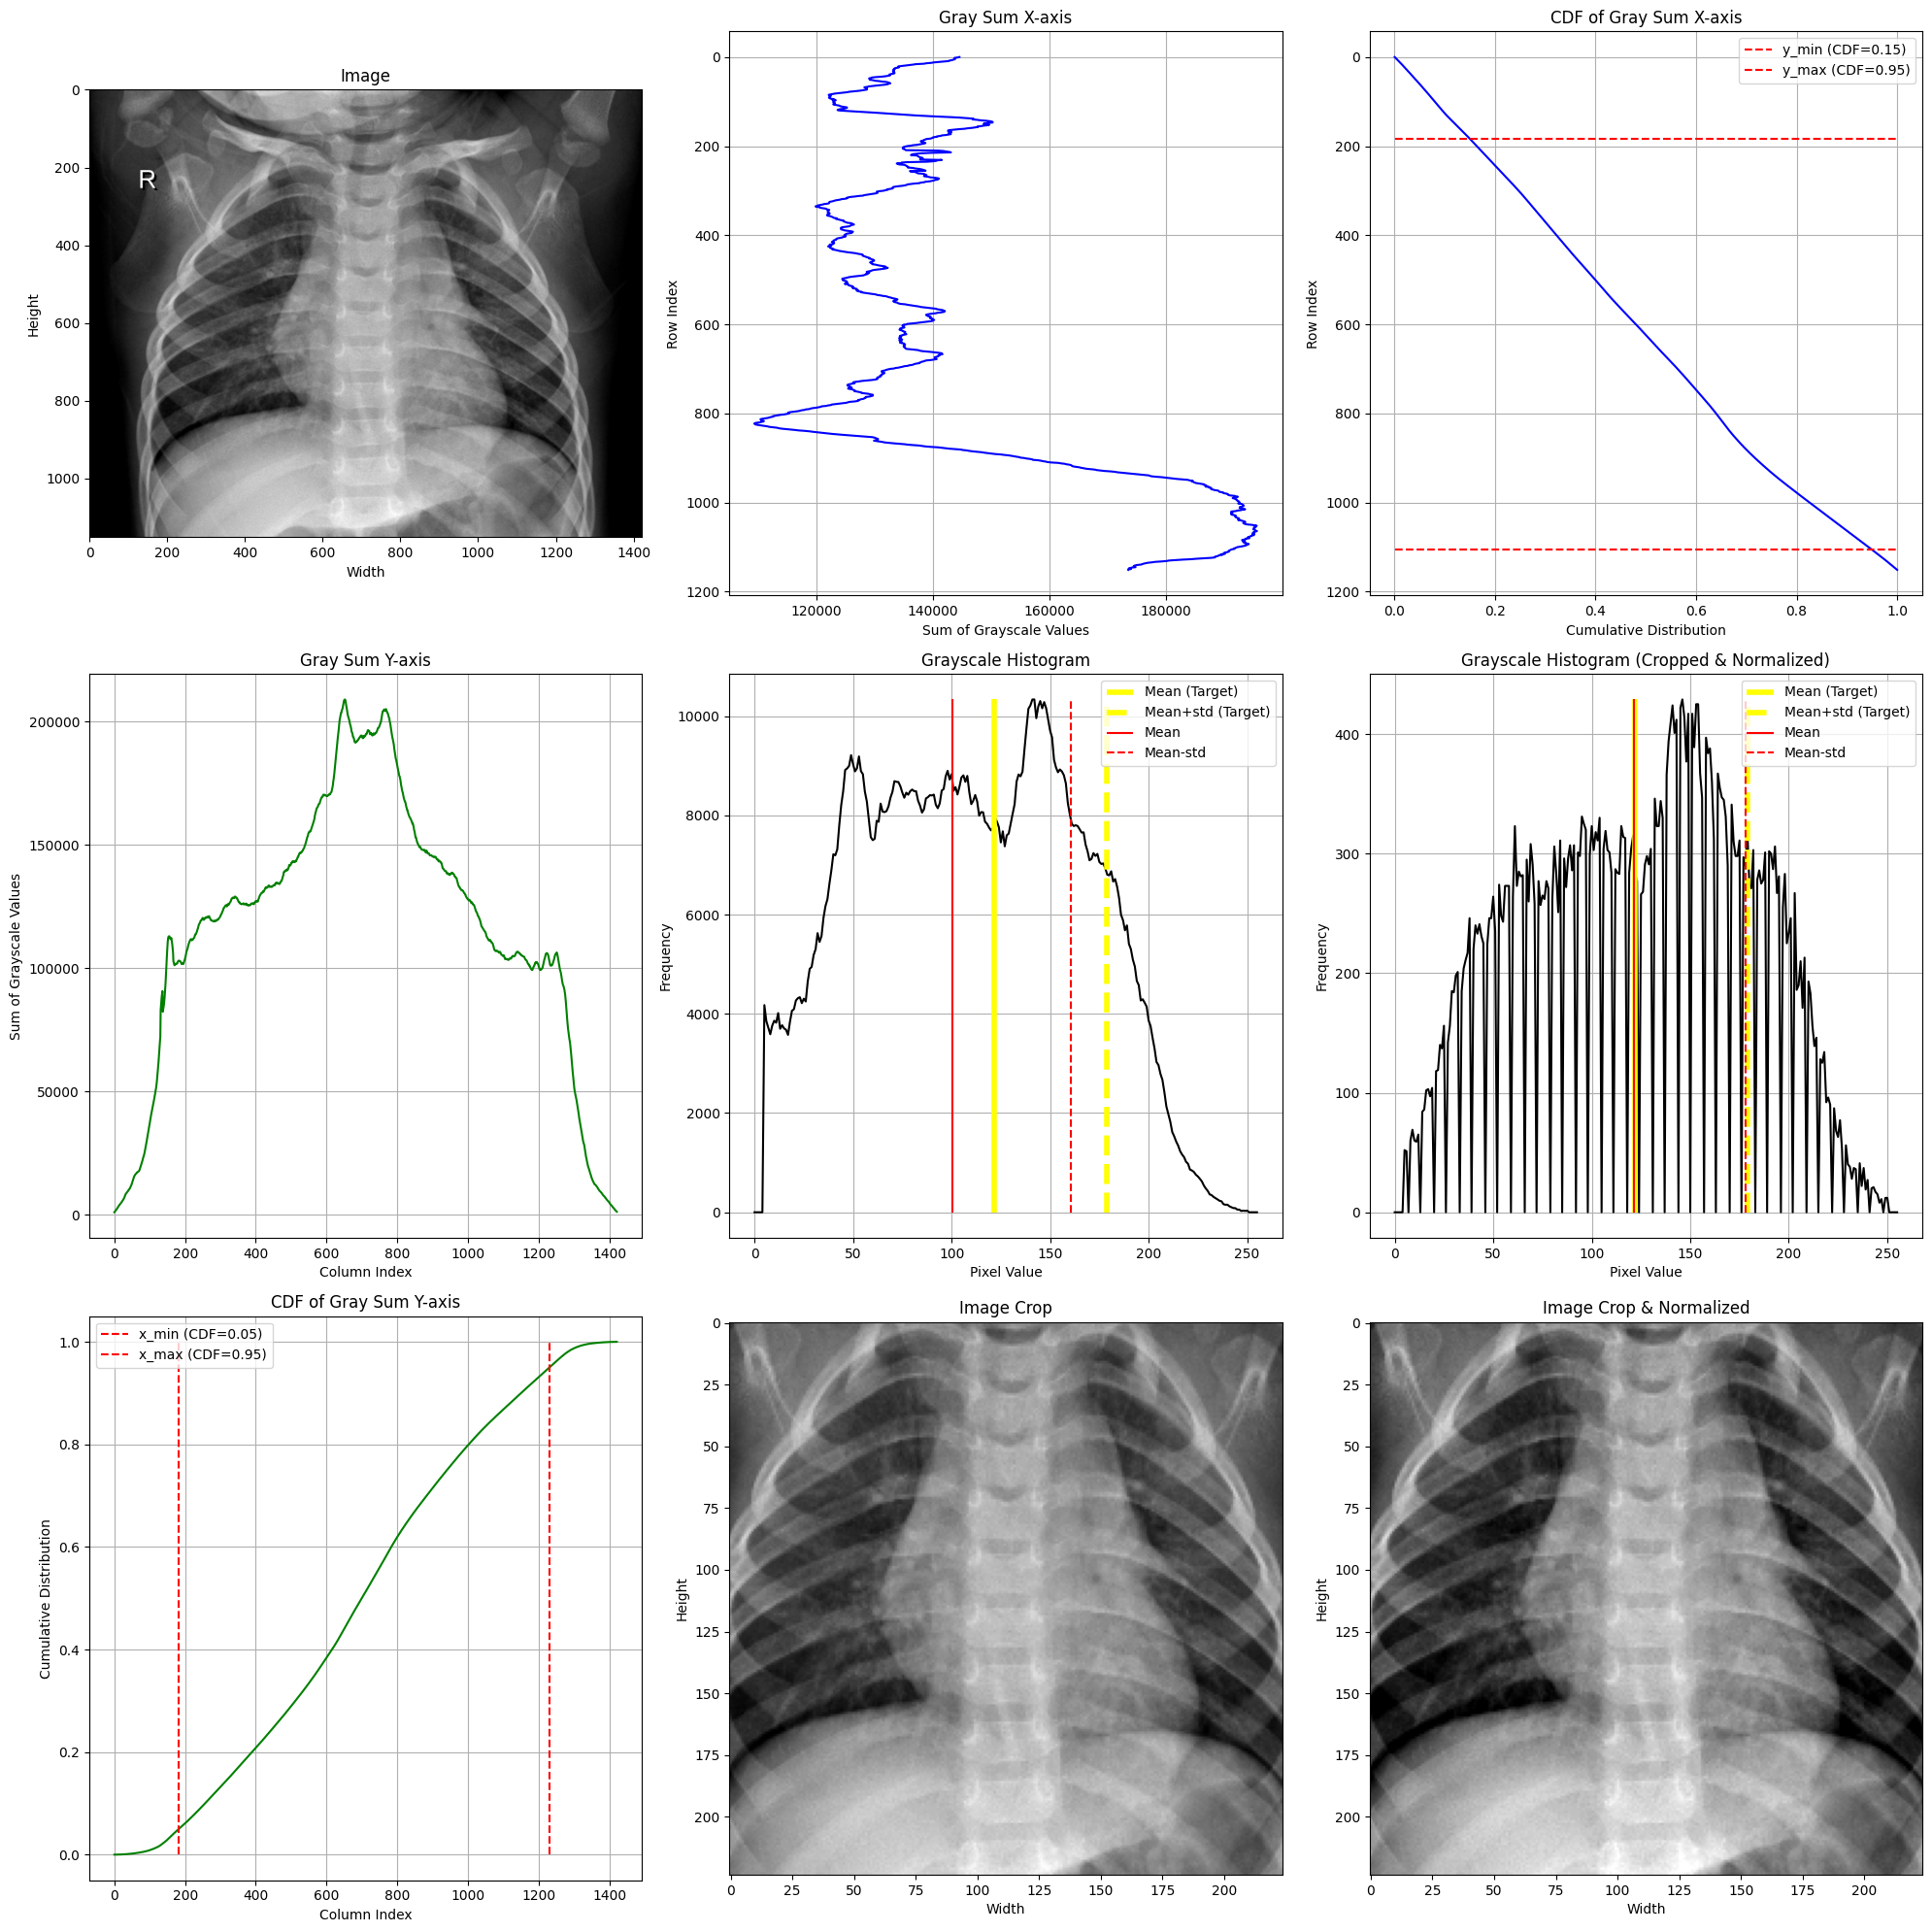

In [319]:
data_dir = r"C:\Users\Study\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2\chest_xray"
date_set = 'train'
class_name = 'NORMAL' # 'PNEUMONIA'
img_name = 'IM-0117-0001.jpeg'# Example usage
image_path = os.path.join(data_dir, date_set, class_name, img_name)
plot_histograms(image_path, crop_gray=True,crop_cdf=True)

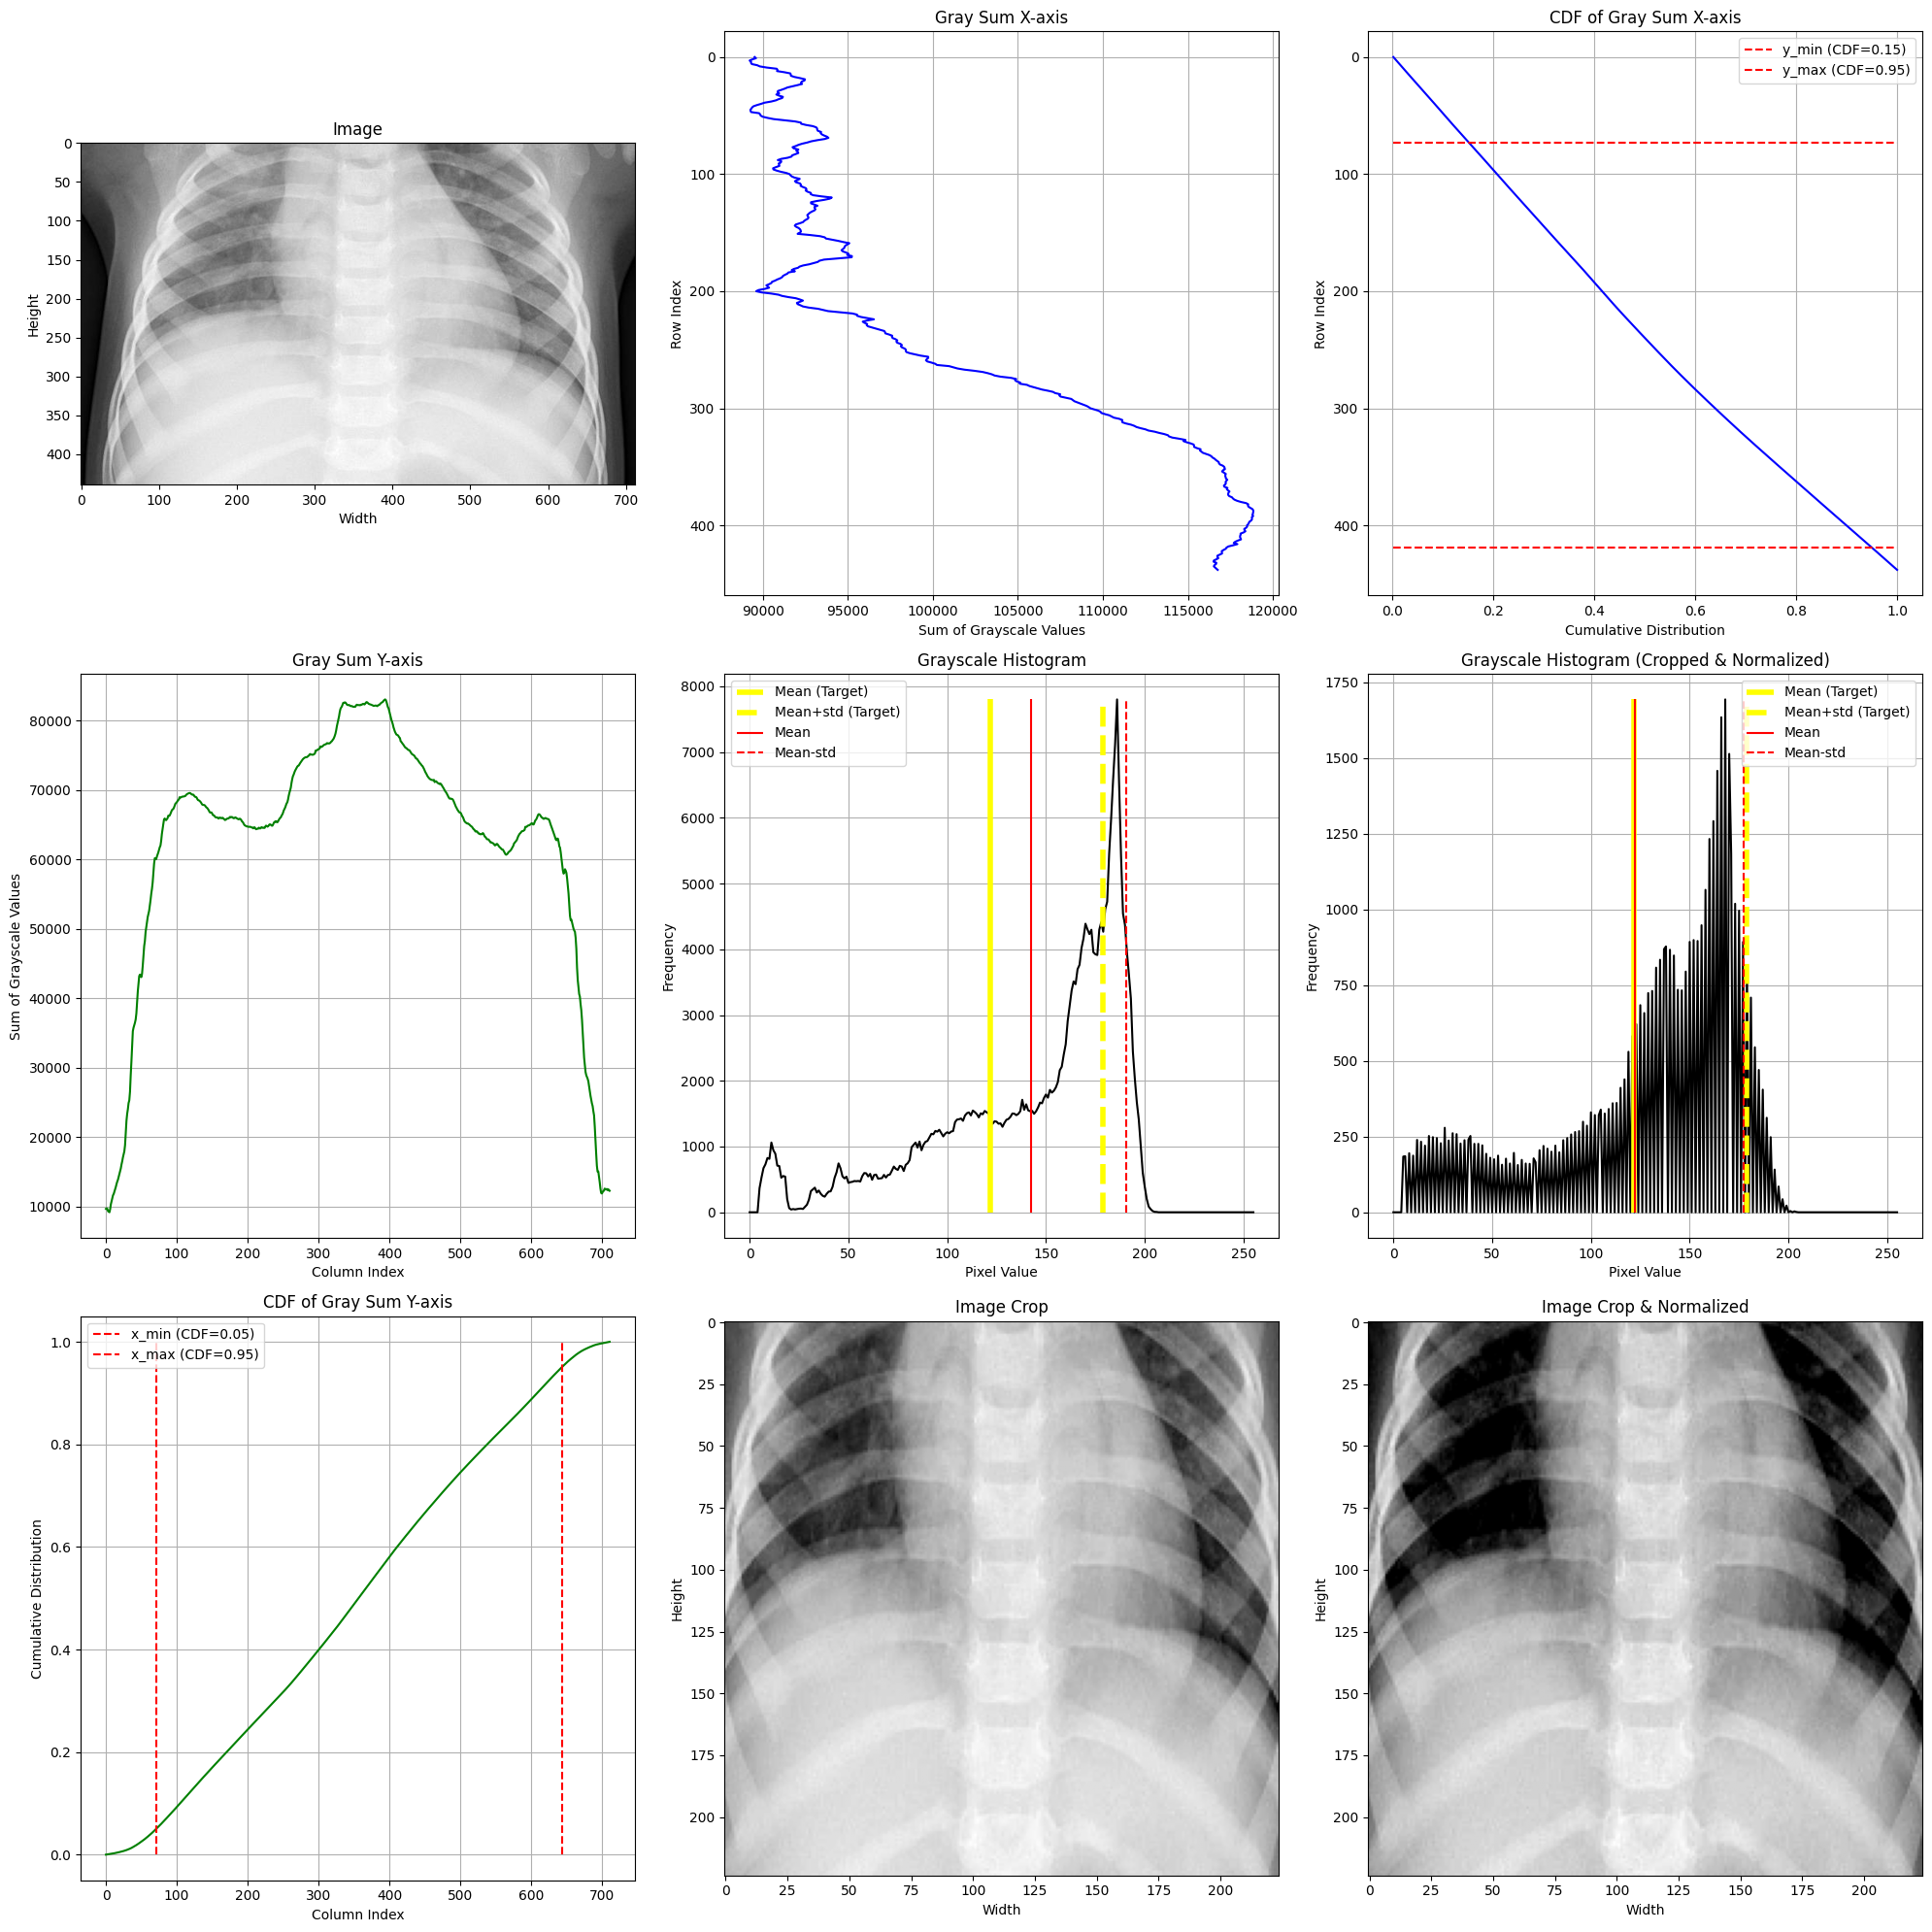

In [320]:
data_dir = r"C:\Users\Study\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2\chest_xray"
date_set = 'train'
class_name = 'PNEUMONIA' # 'PNEUMONIA'
img_name = 'person1_bacteria_1.jpeg'# Example usage
image_path = os.path.join(data_dir, date_set, class_name, img_name)
plot_histograms(image_path, crop_gray=True,crop_cdf=True)

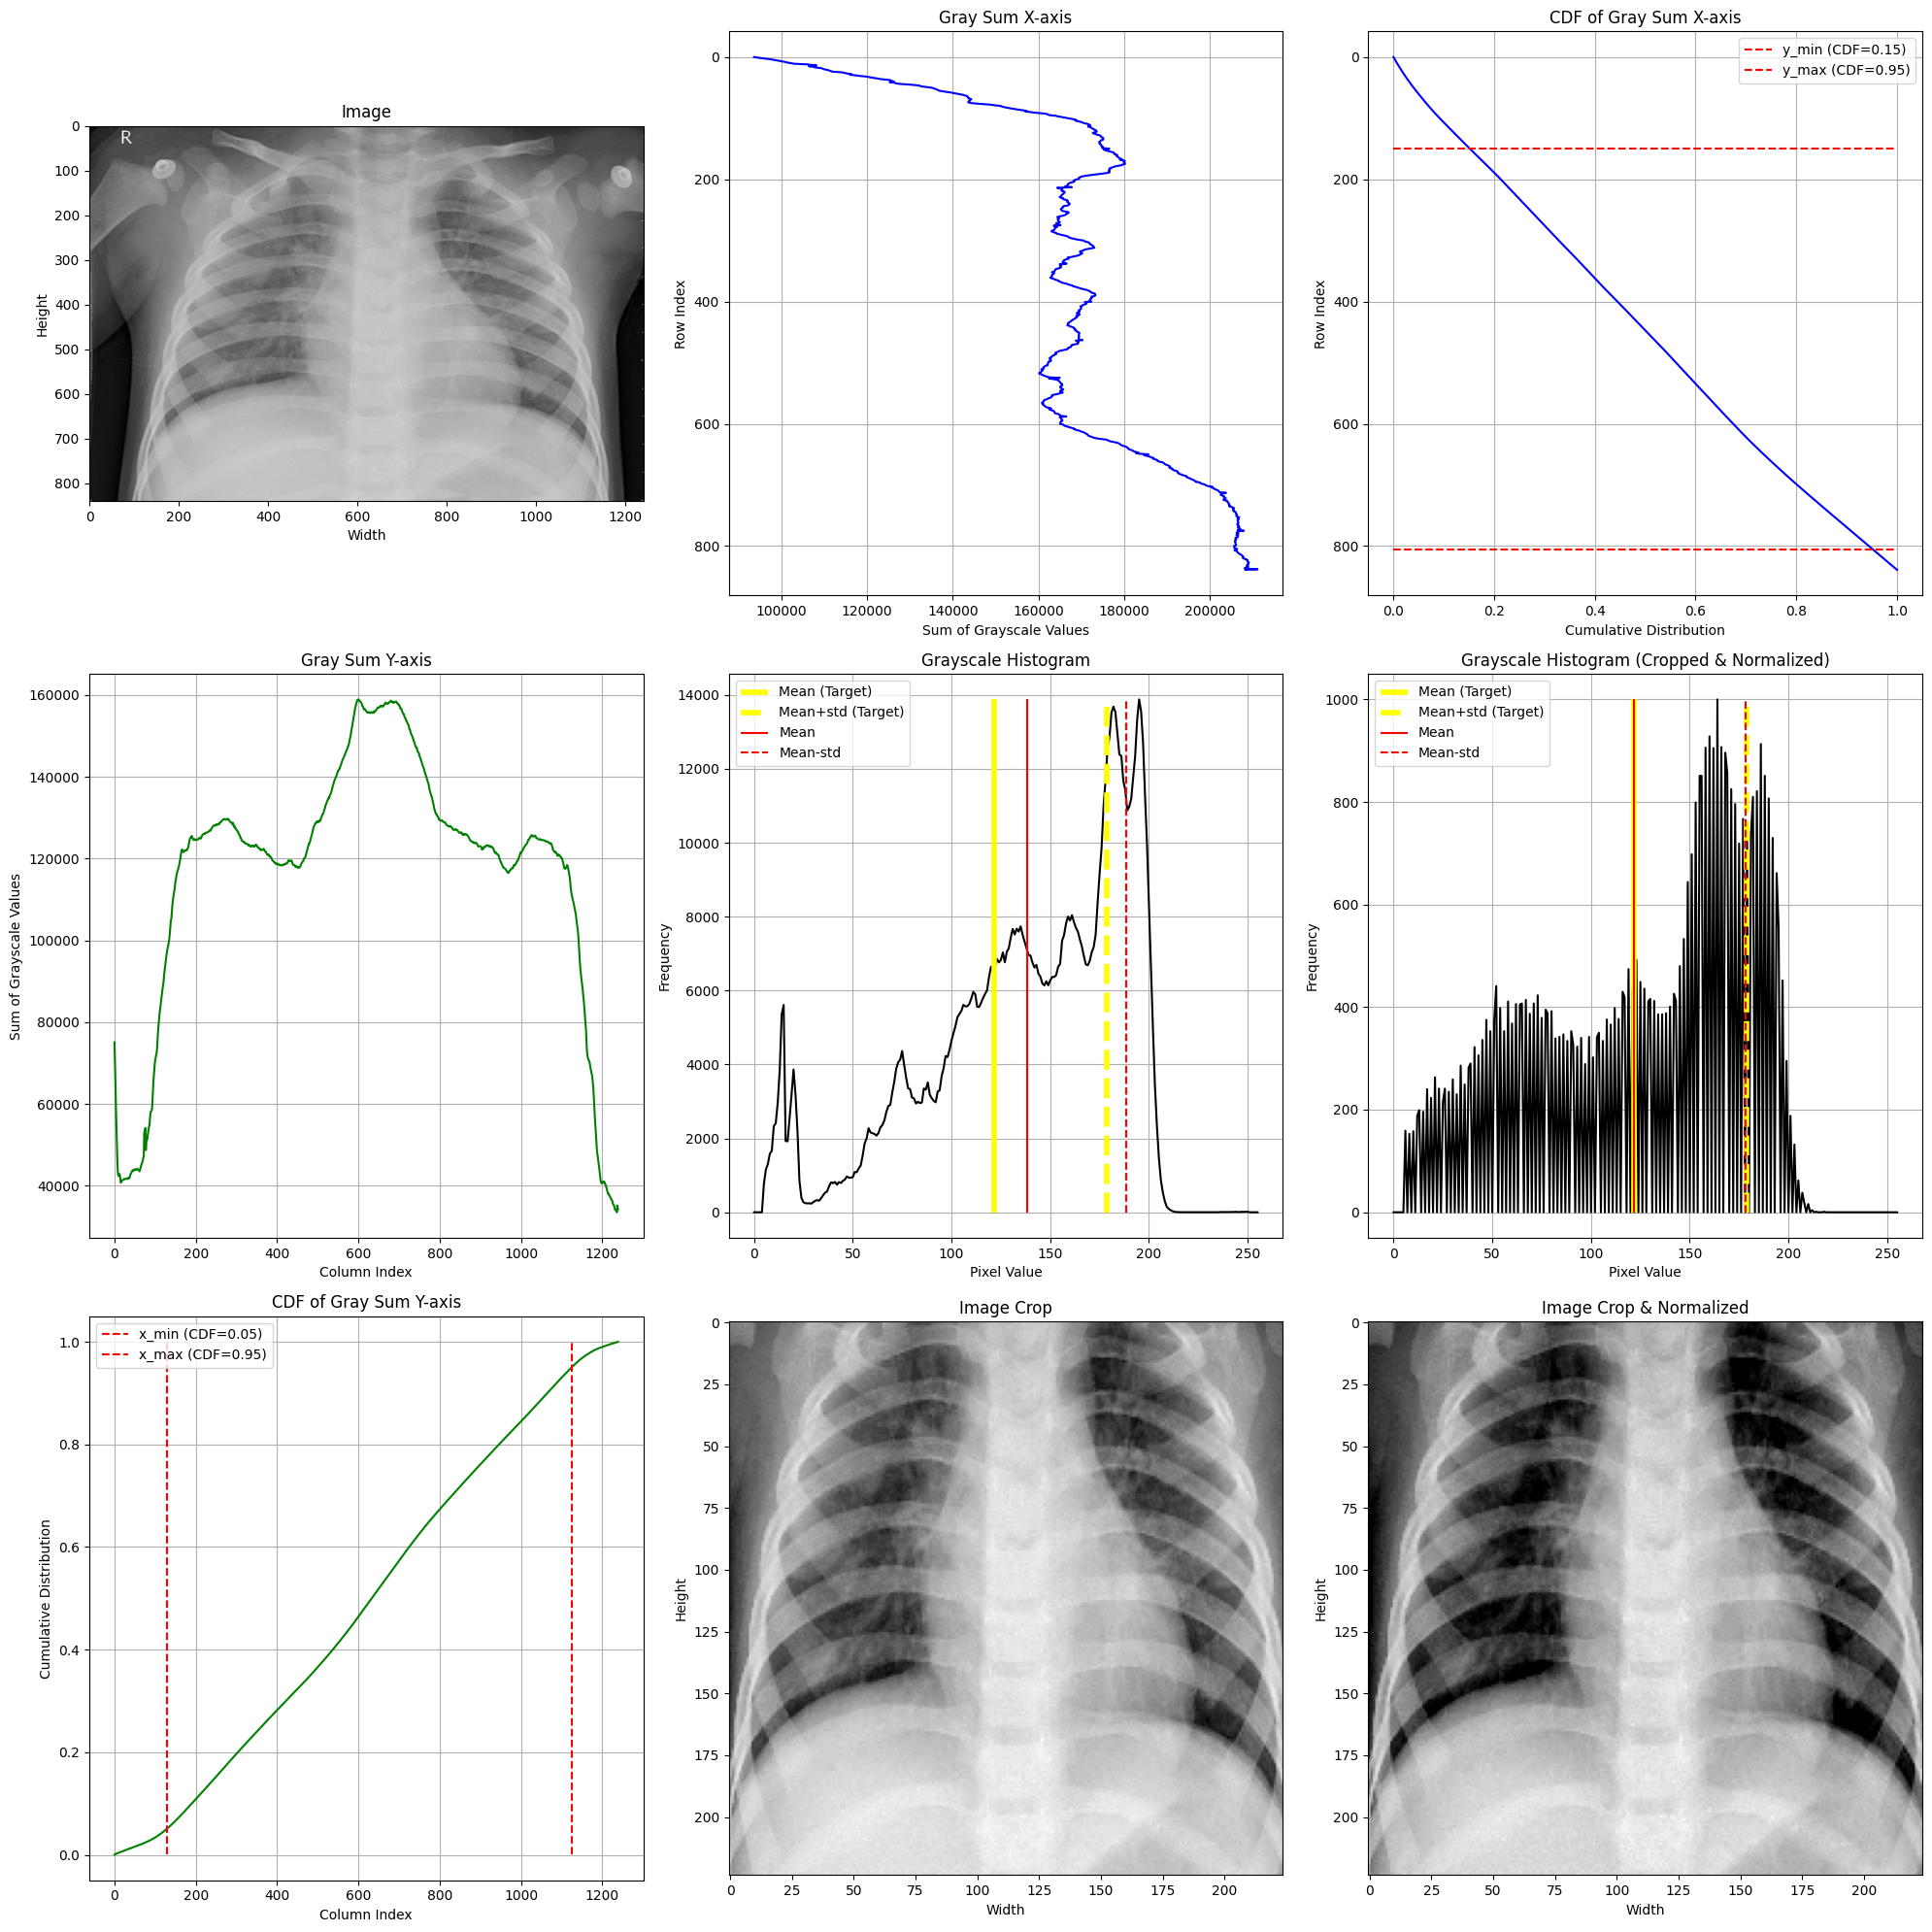

In [321]:
data_dir = r"C:\Users\Study\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2\chest_xray"
date_set = 'train'
class_name = 'PNEUMONIA' # 'PNEUMONIA'
img_name = 'person1_bacteria_2.jpeg'# Example usage
image_path = os.path.join(data_dir, date_set, class_name, img_name)
plot_histograms(image_path, crop_gray=True,crop_cdf=True)

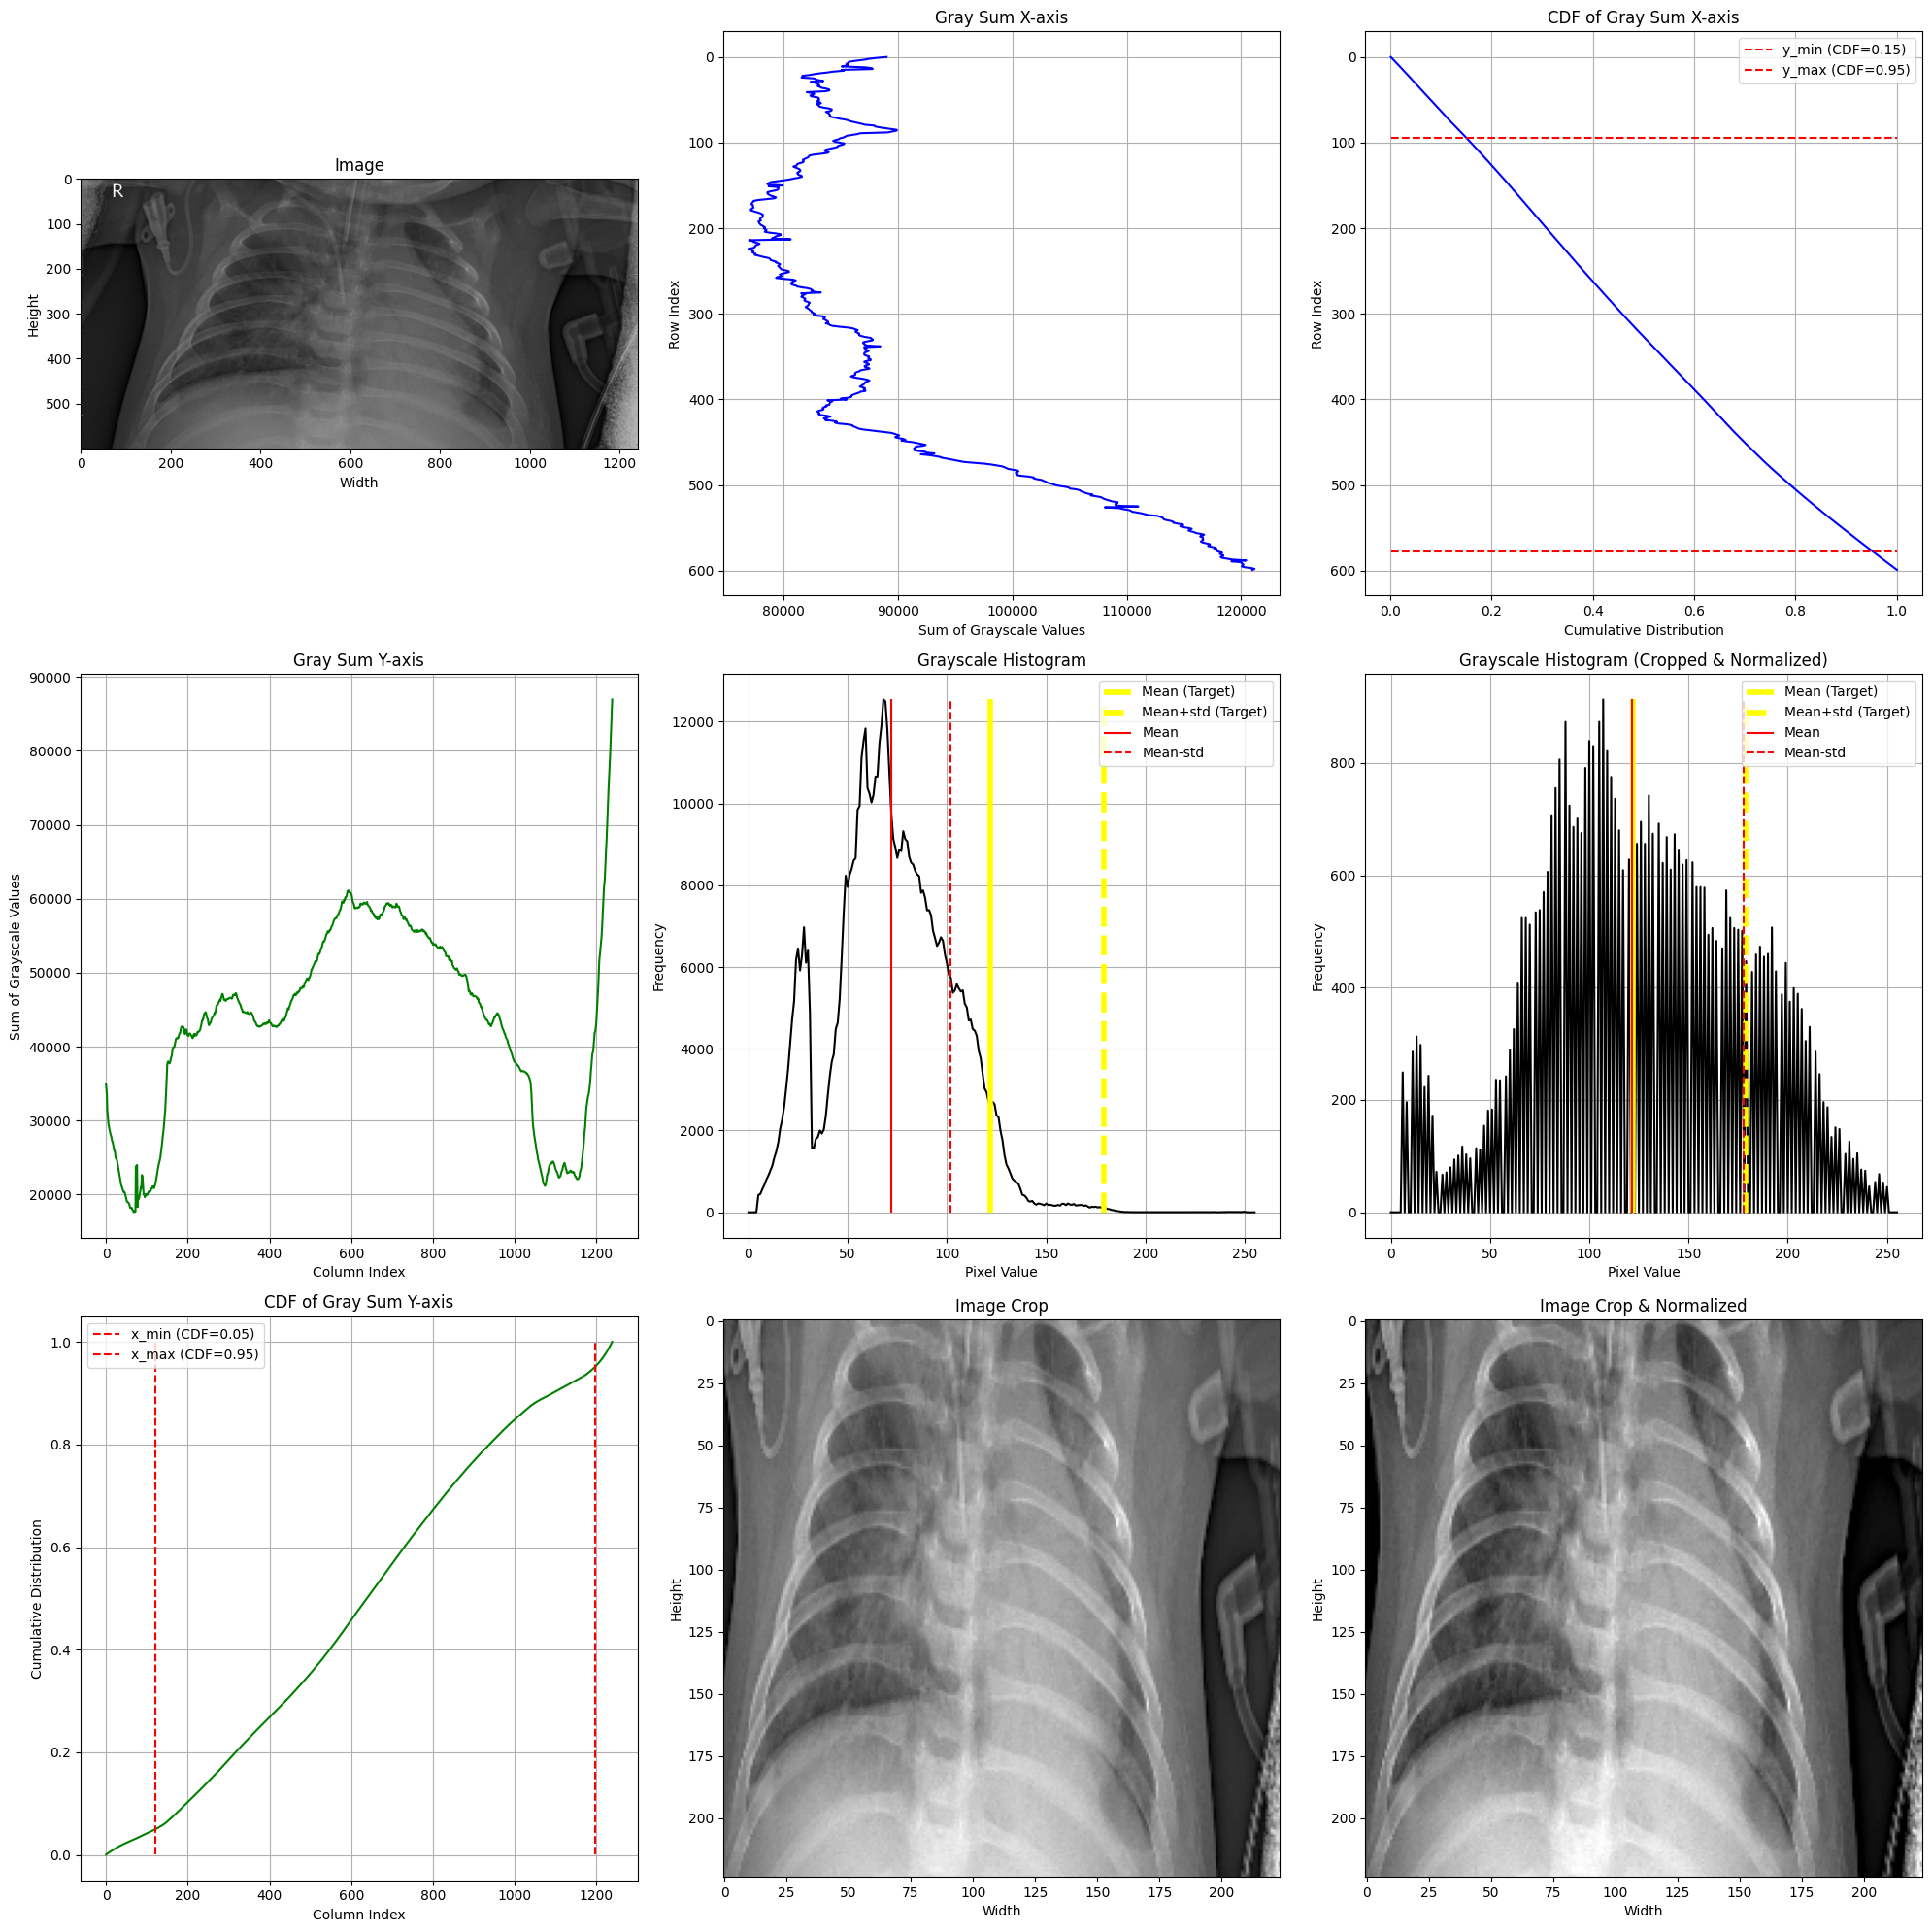

In [322]:
data_dir = r"C:\Users\Study\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2\chest_xray"
date_set = 'train'
class_name = 'PNEUMONIA' # 'PNEUMONIA'
img_name = 'person394_bacteria_1791.jpeg'# Example usage
image_path = os.path.join(data_dir, date_set, class_name, img_name)
plot_histograms(image_path, crop_gray=True,crop_cdf=True)

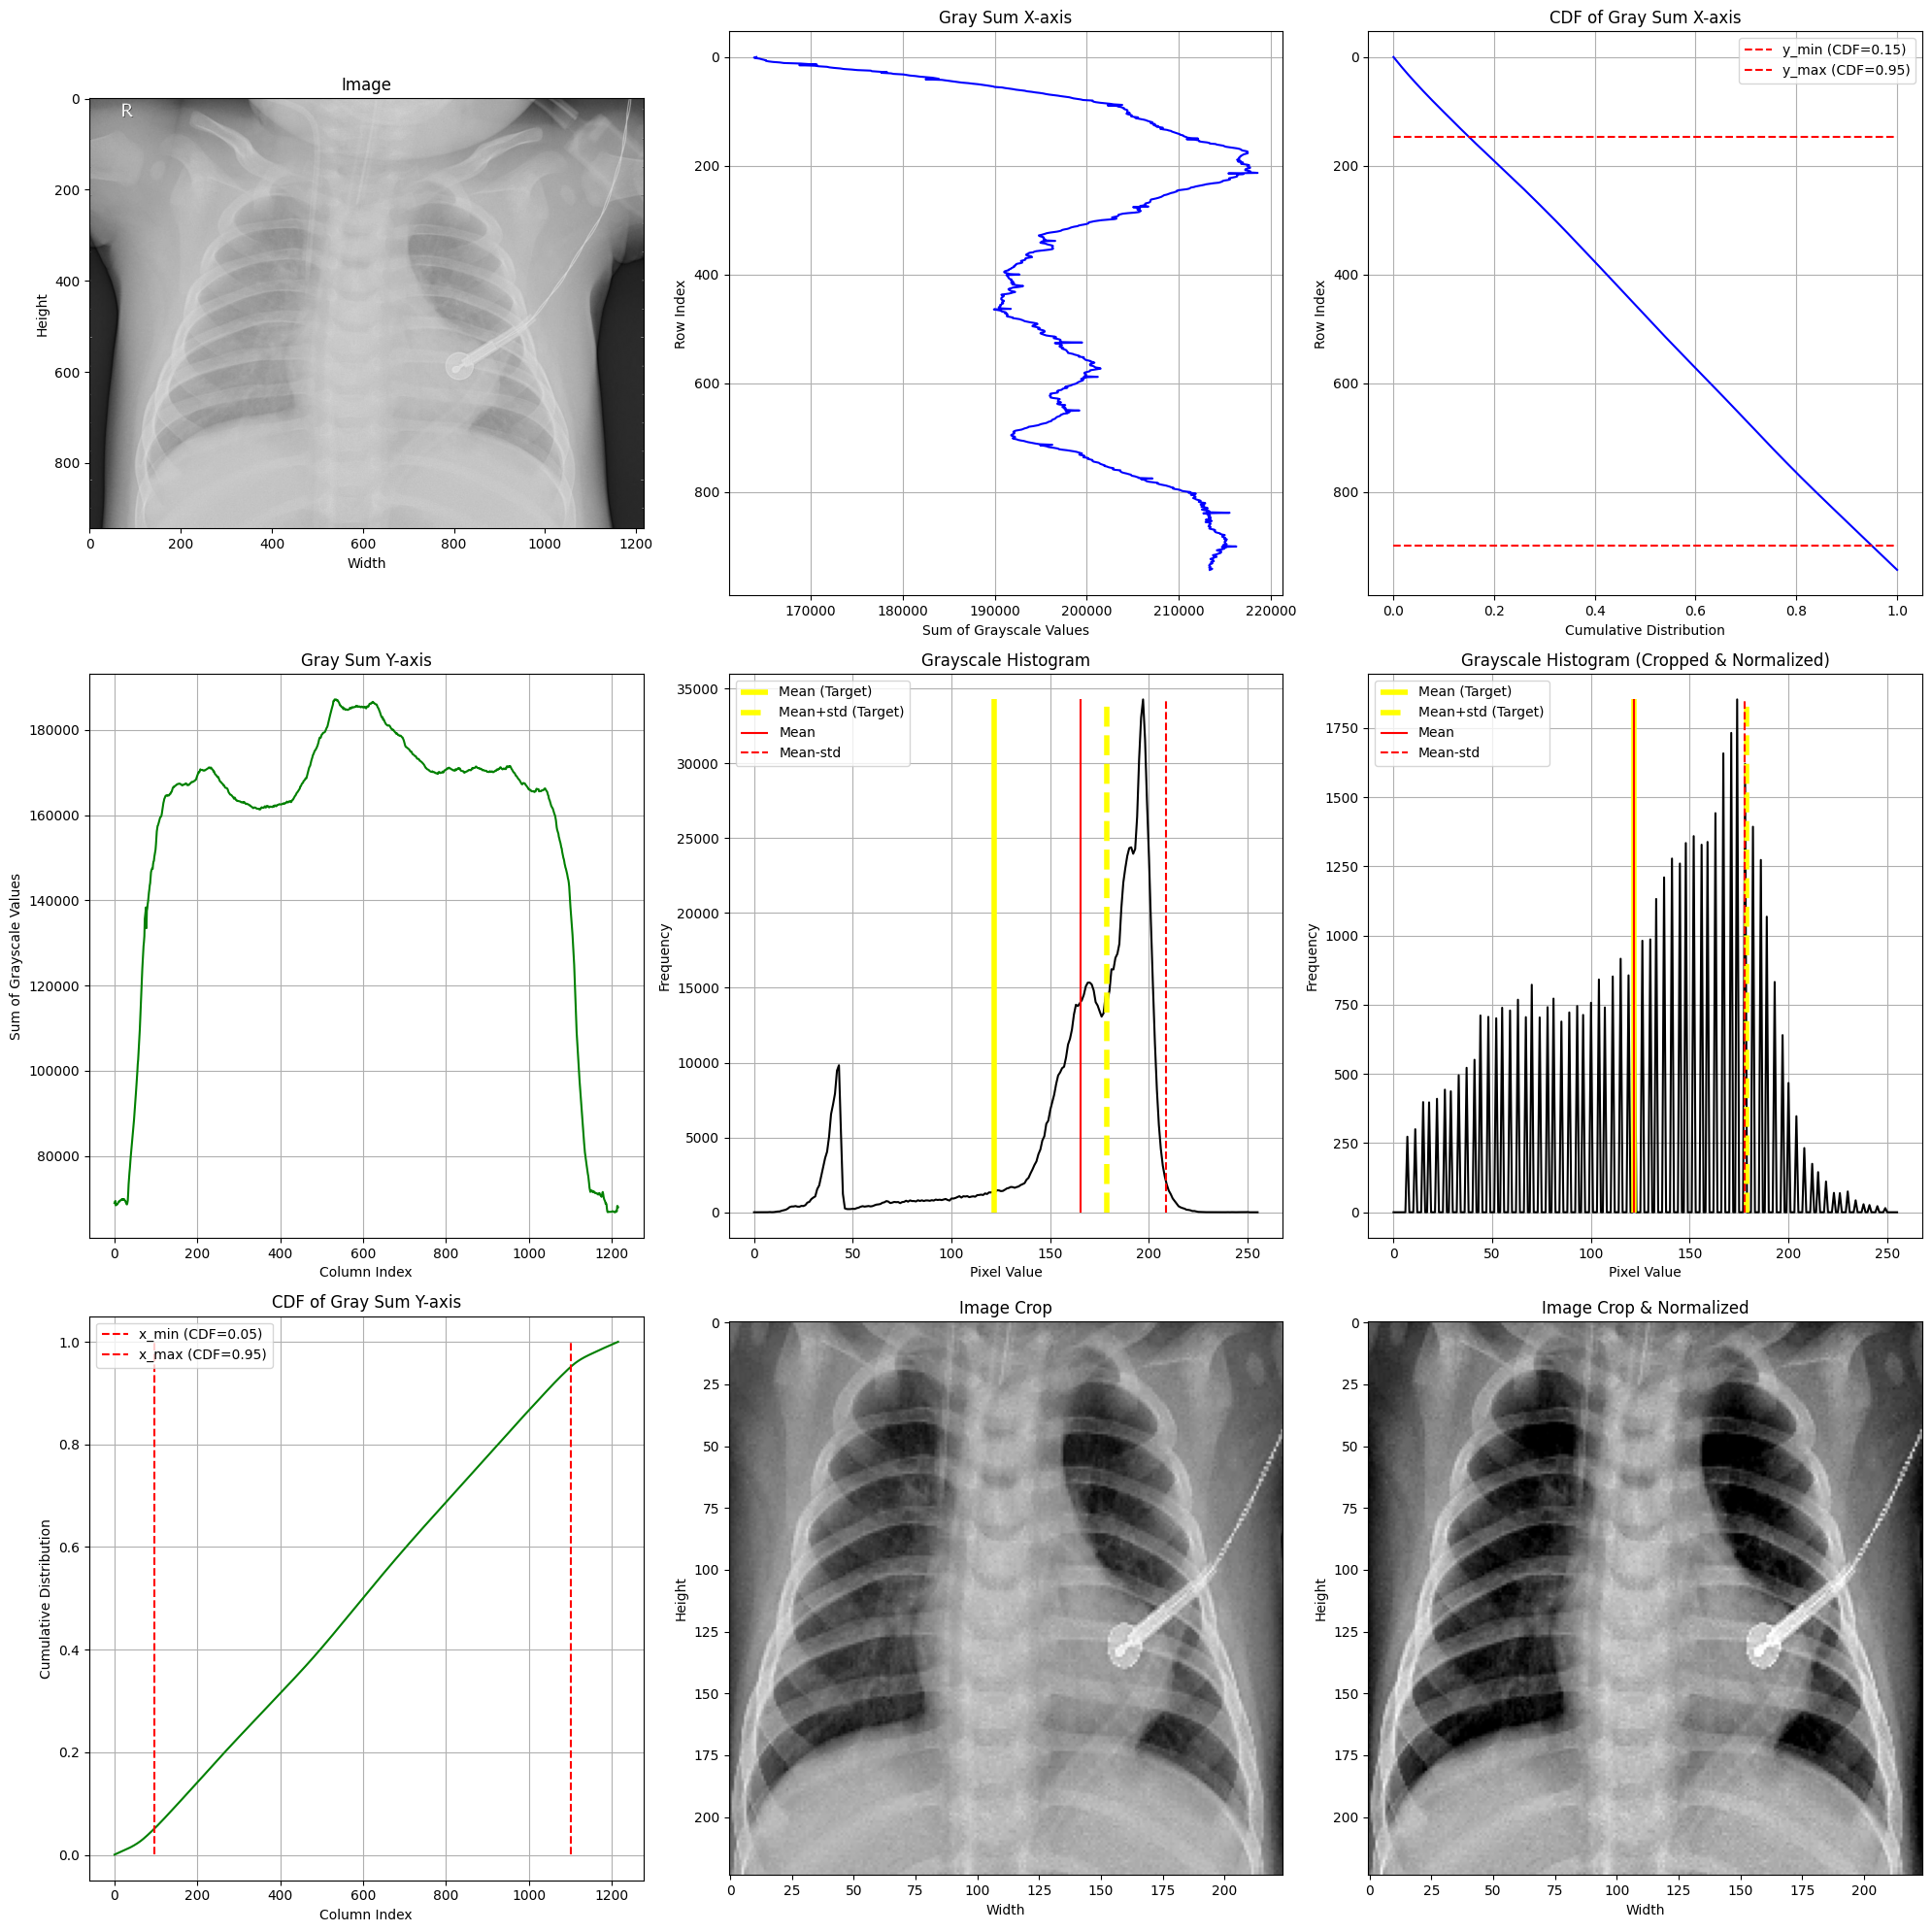

In [323]:
data_dir = r"C:\Users\Study\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2\chest_xray"
date_set = 'train'
class_name = 'PNEUMONIA' # 'PNEUMONIA'
img_name = 'person373_bacteria_1707.jpeg'# Example usage
image_path = os.path.join(data_dir, date_set, class_name, img_name)
plot_histograms(image_path, crop_gray=True,crop_cdf=True)

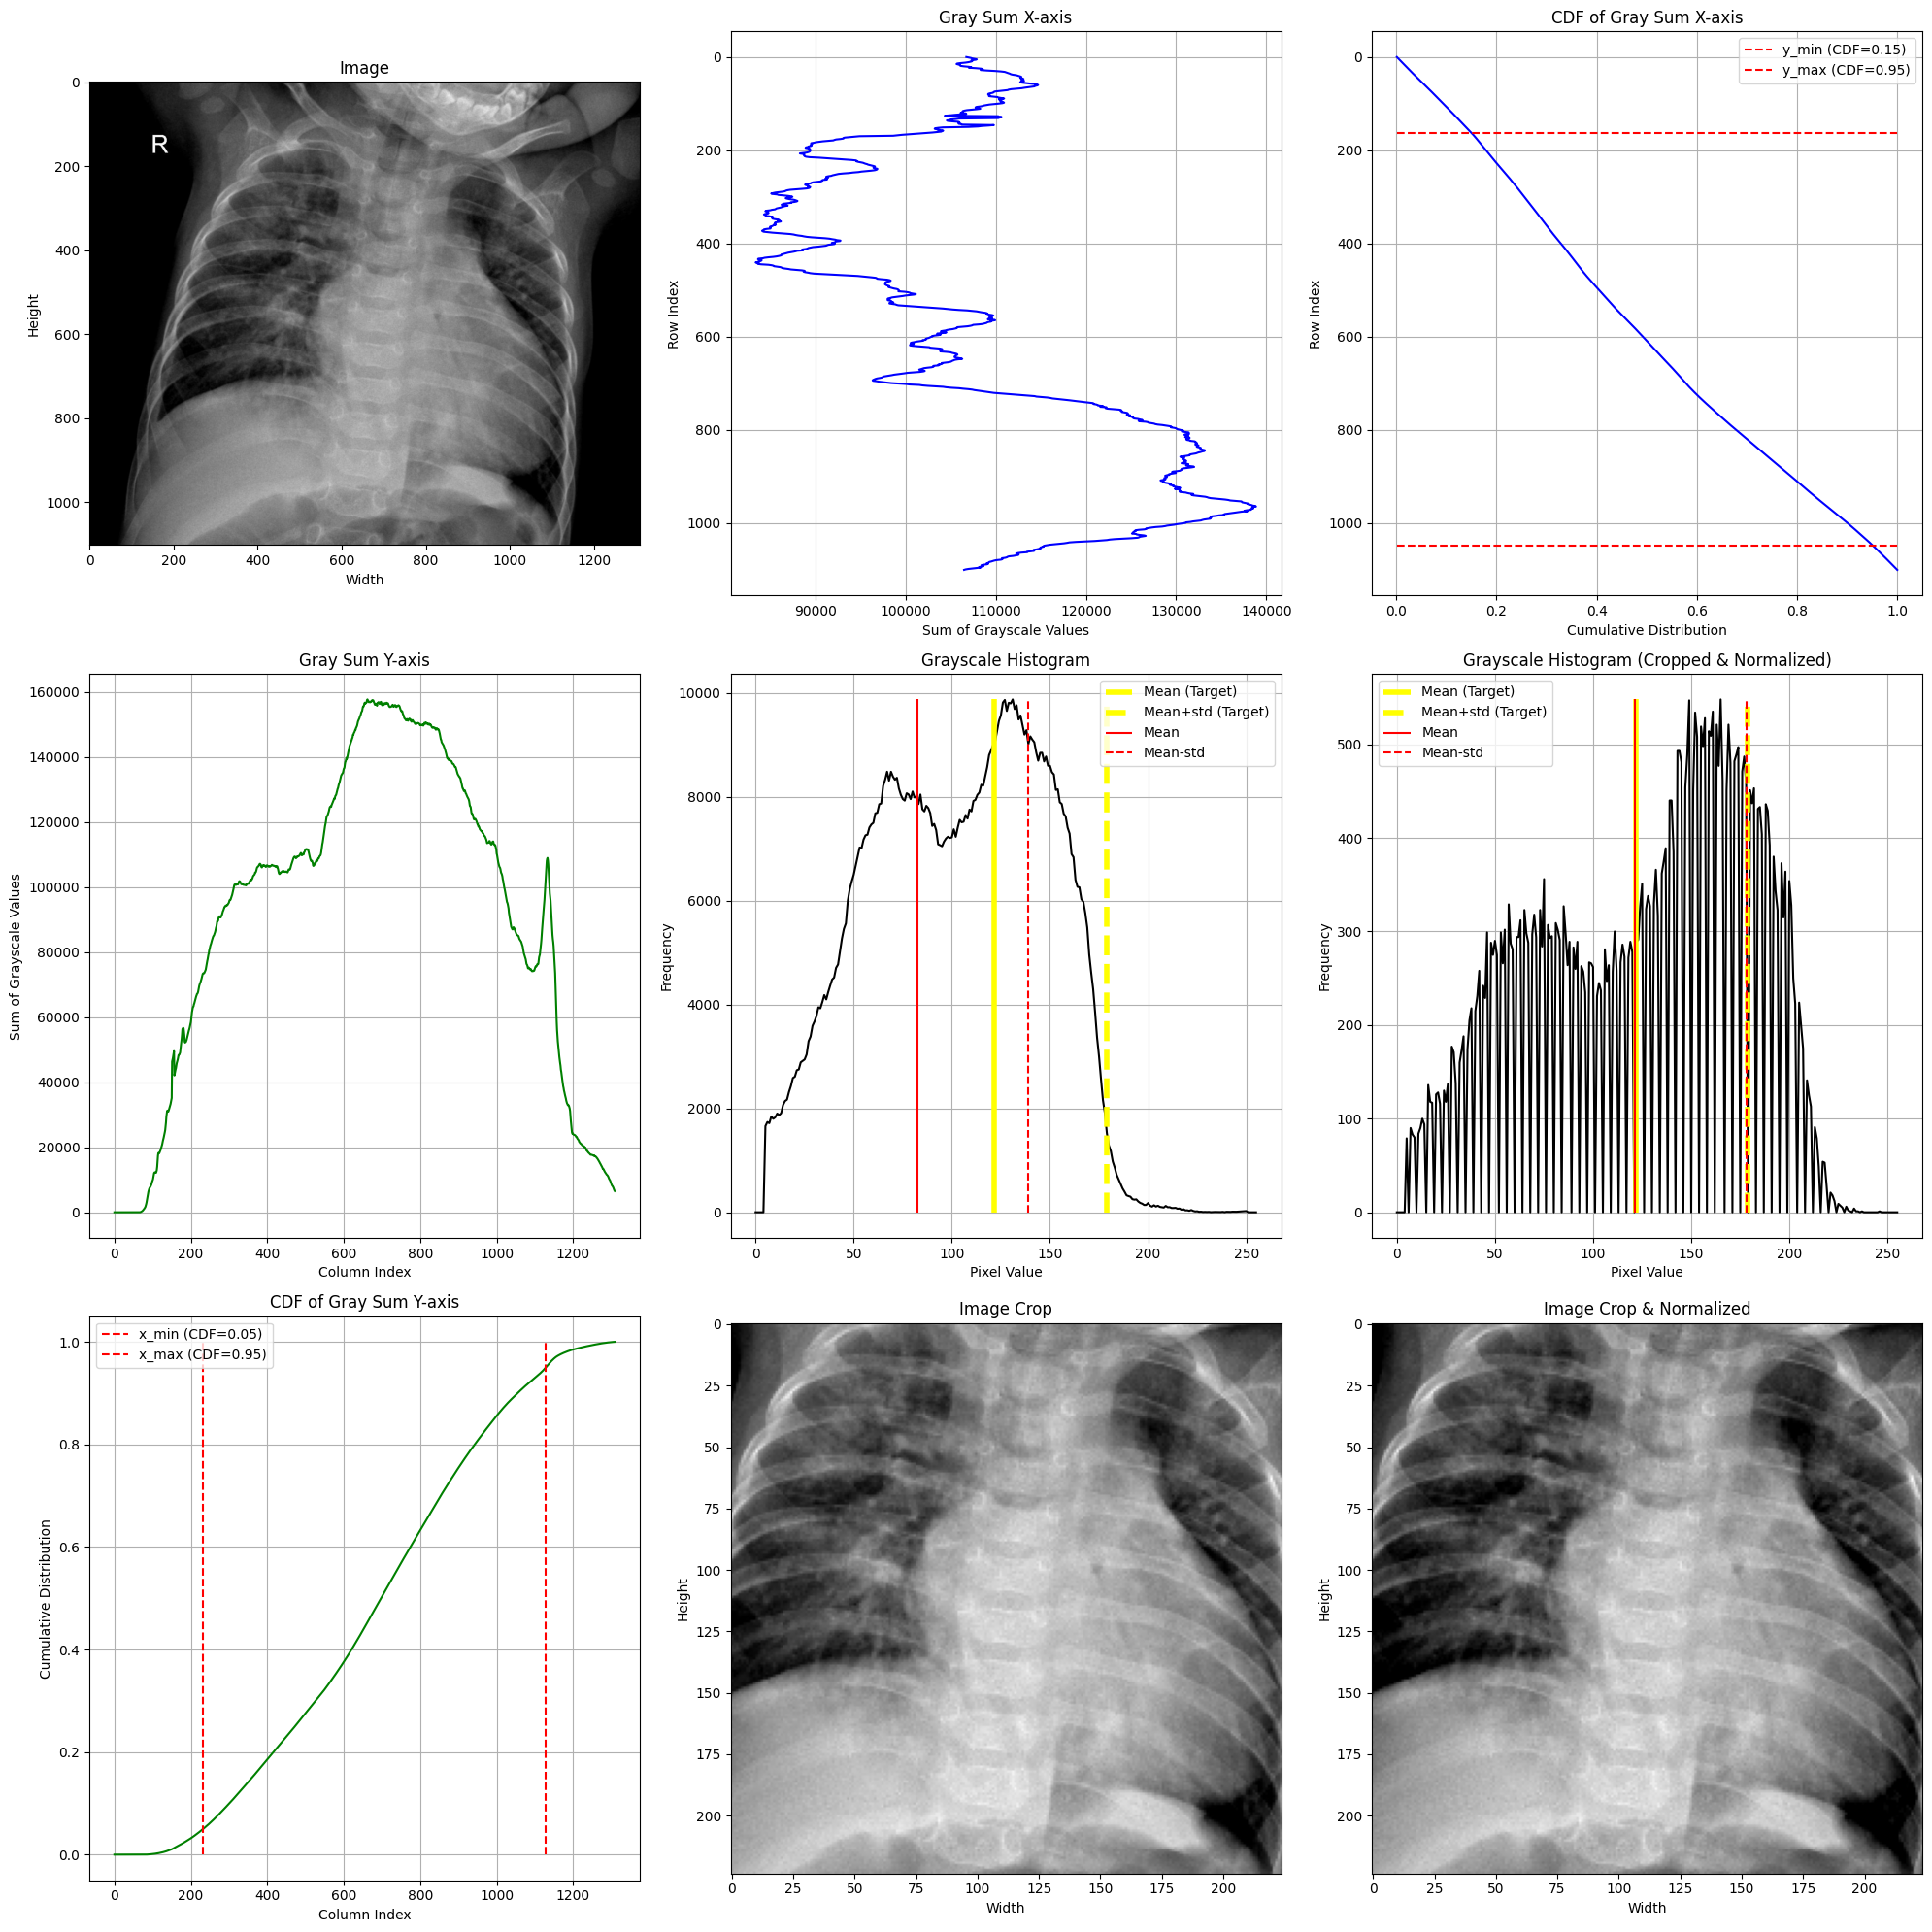

In [324]:
data_dir = r"C:\Users\Study\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2\chest_xray"
date_set = 'train'
class_name = 'PNEUMONIA' # 'PNEUMONIA'
img_name = 'person314_bacteria_1462.jpeg'# Example usage
image_path = os.path.join(data_dir, date_set, class_name, img_name)
plot_histograms(image_path, crop_gray=True,crop_cdf=True)

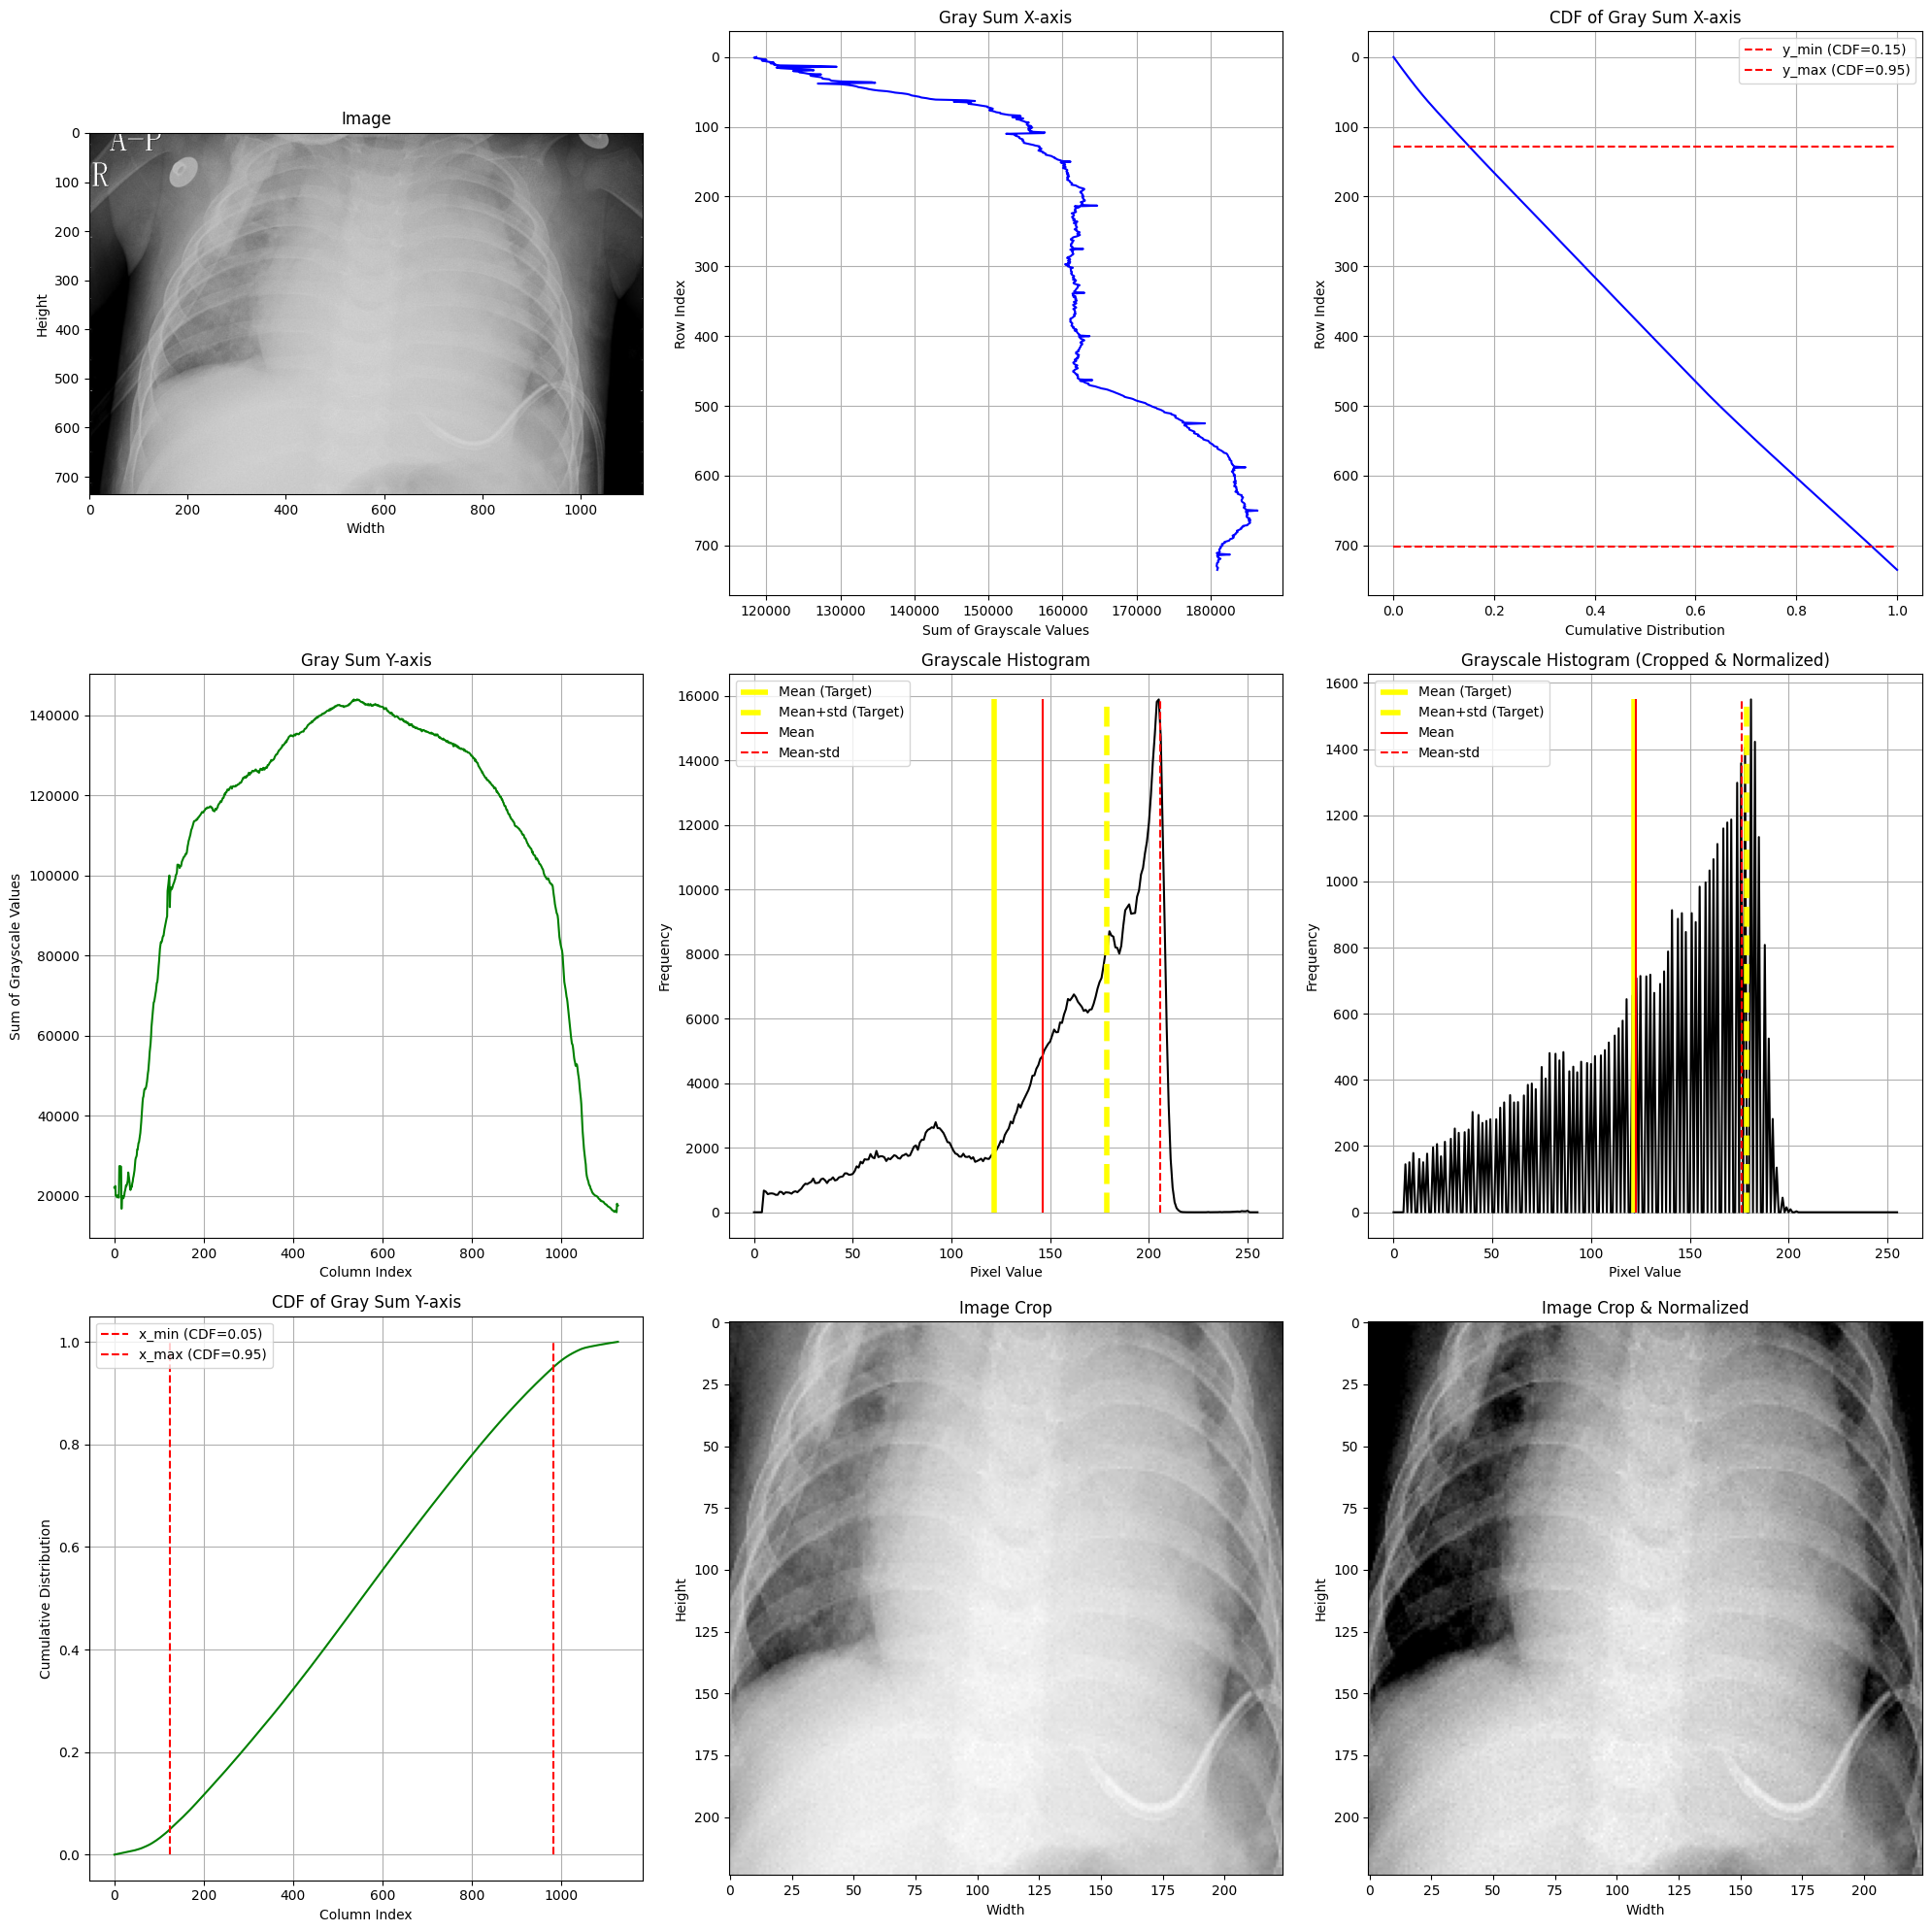

In [325]:
data_dir = r"C:\Users\Study\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2\chest_xray"
date_set = 'train'
class_name = 'PNEUMONIA' # 'PNEUMONIA'
img_name = 'person309_virus_632.jpeg'# Example usage
image_path = os.path.join(data_dir, date_set, class_name, img_name)
plot_histograms(image_path, crop_gray=True,crop_cdf=True)